`transformer_experimentation.ipynb` did not succeed in learning even a linear function.
This is why here a simple general transformer example is adapted to work on time-series data as in Wu et. al.

# Prelude

In [1]:
import sys
import pathlib as pl
sys.path.insert(0,str(pl.Path("../").absolute()))

In [36]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn # neuronal layers, function objects
import torch.nn.functional as F # contains activation functions
from torch.autograd import Variable # wrapper for tensor
import torch.optim as opt
import numpy as np
import sklearn.preprocessing as skp
from utils.data_loader import load_data
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass, asdict
from typing import *
import datetime
import copy
import datetime

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda


## helpers


In [4]:

def wrapBatch(data):
    data = data
    shape = list(data.shape)
    shape.insert(1,1)
    return np.reshape(data, shape)

def get_mask(dim1: int, dim2: int) -> torch.Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Modified from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    Args:

        dim1: int, for both src and tgt masking, this must be target sequence
              length

        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 


    Return:

        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1).to(device)


## Define Transformer

define encoder

In [5]:
# adapted from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.2, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term) # TODO: why does this crash when d_model = 3?
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Encoder(nn.Module):
    def __init__(self, d_input, d_model, nhead=1):
        super(Encoder, self).__init__()

        # define layers (layers are functions)
        self.input_layer = nn.Linear(d_input, d_model) # input layer, 10 features in, 10 features out (== keras dense)
        self.pos_encoding_layer = PositionalEncoding(d_model,dropout=0.2)
        self.encoder_layers = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.2), num_layers=4) # stacks multiple encoder layers, contains self attention and feed forward with normalization in between, TODO: how many heads?

    # forward pass data x through network
    def forward(self, x: torch.Tensor):
        x = self.input_layer(x)
        x = self.pos_encoding_layer(x)
        x = self.encoder_layers(x)
        return x[0] # we ignore batching here, expected shape of x: [batch][pos in seq][dim]

define decoder

In [6]:

class Decoder(nn.Module):
    def __init__(self, d_input, d_model, nhead=1):
        super(Decoder, self).__init__()

        # define layers (layers are functions)
        self.input_layer = nn.Linear(d_input, d_model) # input layer, 10 features in, 10 features out (== keras dense)
        self.decoder_layers = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=0.2), num_layers=4)
        self.linear_mapping = nn.Linear(
            in_features=d_model, 
            out_features=d_input
            )


    # forward pass data x through network
    def forward(self, x: torch.Tensor, memory: torch.Tensor, mask: torch.Tensor): #NOTE: TODO: implement Masking
        x = self.input_layer(x)
        x = self.decoder_layers(x,memory=memory,tgt_mask=mask)
        x = self.linear_mapping(x)
        return x
    

In [7]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_input, d_model,nhead=8):
        super(TimeSeriesTransformer, self).__init__()

        # define layers
        self.encoder = Encoder(d_input, d_model,nhead=nhead)
        self.decoder = Decoder(d_input, d_model,nhead=nhead)

        self.memory = None

    def encode(self, src: torch.Tensor):
        encoding = self.encoder(src)
        self.memory = encoding

    def forward(self, target: torch.Tensor, mask: torch.Tensor):
        if self.memory == None:
            raise ValueError("you need to call encode() first")
        out = self.decoder(x=target,memory=self.memory, mask=mask)
        return out

generate fake data (linear)

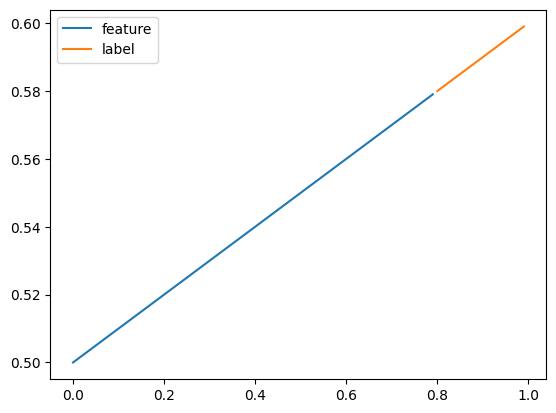

In [8]:
a = 0.1
b = 0.5
data_x = np.arange(0,1,0.01)
data_y = [a*y+b for y in data_x]

# split "window" into feature and label as in Wu et al
rel = 0.8
feature = data_y[:int(rel*len(data_y))]
label = data_y[int(rel*len(data_y)):]
plt.plot(data_x[:int(rel*len(data_y))],feature, label="feature")
plt.plot(data_x[int(rel*len(data_y)):],label, label="label")
plt.legend()

In [9]:
feature = torch.Tensor(feature).to(device)
label = torch.Tensor(label).to(device)

Network Training

In [10]:
#%%
d_input = 1
d_model = 2
nhead = 2
net = TimeSeriesTransformer(d_input, d_model,nhead=nhead)
net.to(device)
net.train(True)
#learning_rate = 2.8*(10**(-6)) # TODO: how is learning schedule implemented by Wu et al?
learning_rate = 0.01
print(f"learning rate {learning_rate}")
optimizer = opt.Adam(net.parameters(), lr=learning_rate,betas=[0.9,0.98], eps=10**(-9))
criterion = nn.MSELoss()
num_epochs = 10 # 500

#%%
losses = []
lr_updated = False
# go through every datapoint (1)
for i in range(num_epochs):
    # apply gradient to each epoch
    net.zero_grad()
    optimizer.zero_grad()
    
    net.encode(torch.unsqueeze(feature,0).T)

    predicted_labels = []
    # we start with last feature label as input(do not use in loss)
    # last label does not get used for input only for error lost
    target_labels = [feature[-1]] + list(label) 
    # train every step in window individually
    for sp in range(len(target_labels)-1):
        decoder_input = target_labels[:sp+1]
        decoder_input = torch.Tensor(decoder_input).to(device)
        decoder_input = torch.unsqueeze(decoder_input,0)
        #decoder_input = torch.unsqueeze(decoder_input,0)
        decoder_input = decoder_input.T
        out = net.forward(decoder_input,None) #TODO: add Masking
        newly_predicted = out[-1] # always only one new because of shifted label prediction
        predicted_labels.append(newly_predicted) 
        
    # first label was only to feed input
    y_label = torch.tensor(target_labels[1:]).to(device)
    y_predicted = torch.squeeze(torch.stack(predicted_labels))
    #print(y_label.shape, y_predicted)
    loss = criterion(y_label, y_predicted)
    loss.backward()
    optimizer.step()
    if i > 250 and lr_updated == False:
        optimizer.param_groups[0]['lr'] = 0.0000001 #1e-7
        lr_updated = True
        print(f"new learning rate {optimizer.param_groups[0]['lr']}")
    if i % 10 == 0: print(f"{i}: loss={loss}")

#%%
# example result of trained net and conversion to numpy
#x_numpy = np.array([1,0,0,0,1,0,0,0,1,1])
#x = torch.Tensor(x_numpy).to(net.device)
#y = net(x)
#y_numpy = y.detach().cpu().numpy()
#print("in  ", x_numpy.astype(np.int8))
#print("out ", np.abs(np.rint(y_numpy)).astype(np.int8)) # as nearest (positive) int
# %% 

learning rate 0.01
0: loss=3.973926544189453


In [11]:
net.encode(torch.unsqueeze(feature,0).T)
res = torch.Tensor(torch.unsqueeze(label,0).T).to(device)
out = net(res,None)
out

tensor([[ 0.5395],
        [ 0.5395],
        [ 0.5395],
        [ 0.5395],
        [ 0.5395],
        [ 0.5395],
        [ 0.5395],
        [ 0.5395],
        [ 0.5395],
        [ 0.5395],
        [ 0.5395],
        [ 0.5395],
        [ 0.5395],
        [ 0.5395],
        [ 0.5395],
        [-1.2364],
        [ 0.5395],
        [ 0.5395],
        [ 0.5395],
        [ 0.5395]], device='cuda:0', grad_fn=<AddmmBackward0>)

it seems that at least something is learned here

In [12]:
label

tensor([0.5800, 0.5810, 0.5820, 0.5830, 0.5840, 0.5850, 0.5860, 0.5870, 0.5880,
        0.5890, 0.5900, 0.5910, 0.5920, 0.5930, 0.5940, 0.5950, 0.5960, 0.5970,
        0.5980, 0.5990], device='cuda:0')

In [13]:
np.var(label.cpu().detach().numpy())

3.325002e-05

In [14]:
np.var(out.cpu().detach().numpy())

0.1498042

# Try with real data

In [15]:
data_temp, data_wind = load_data()
display(data_temp.head(3))
display(data_wind.head(3))

,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:42,526487,467544,442
1,2022-01-22 13:53:44,526542,467315,461
2,2022-01-22 13:53:45,526532,466868,466


,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:37,505940,507749,621
1,2022-01-22 13:53:38,505846,507807,632
2,2022-01-22 13:53:40,505990,507764,629


In [16]:
def scale_and_resample_timeindex(df: pd.DataFrame, timefreq="10s", aggregator="mean"):
    df = df.set_index("timestamp")
    df = df[~df.index.duplicated(keep="first")]
    df = df.resample(timefreq).aggregate(aggregator)
    scaler = skp.MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    return df, scaler

In [50]:
data = data_temp.copy().iloc[:1000,:]
timefreq="5s"
aggregator="mean"
window_size=12
feature_size=10

def get_window(data, i, wsize):
    """i is starting index of window"""
    window = data.iloc[i:i+wsize, 1:].to_numpy()
    timestamps = data.iloc[i:i+wsize, 0].to_numpy()
    isvalid = not np.any(np.isnan(window))
    if window.shape[0] != wsize:
        isvalid = False
    return window, timestamps, isvalid

def get_datapoint(data, i, wsize, fsize):
    window, timestamps, isvalid = get_window(data, i, wsize)
    feature, label = window[0:fsize,:], window[fsize:,:]
    return feature, label, timestamps, isvalid

def get_valid_windows(data, wsize):
    valid_indexes = []
    print("computing valid windows")
    for i in tqdm(range(data.shape[0])):
        _,_, isvalid = get_window(data,i,wsize)
        if isvalid:
            valid_indexes.append(i)
    print(f"found {len(valid_indexes)} valid window(s)")
    return valid_indexes

data_resampled, scaler = scale_and_resample_timeindex(data, timefreq=timefreq, aggregator=aggregator)
data_resampled = data_resampled[["differential_potential_CH1"]]
data_resampled = data_resampled.reset_index()
valid_windows = get_valid_windows(data_resampled, window_size)
window, timestamps, isvalid = get_window(data_resampled, valid_windows[0],window_size)
feature, label, timestamps, isvalid = get_datapoint(data_resampled, valid_windows[0], window_size, feature_size)

computing valid windows


100%|██████████| 348/348 [00:00<00:00, 5356.30it/s]

found 337 valid window(s)


In [276]:
@dataclass(frozen=True,slots=True)
class ExperimentData:
    data_resampled: pd.DataFrame
    scaler: skp.MinMaxScaler
    timefreq: str
    aggregator: str|Callable
    columns: list[str]
    window_size: int
    feature_size: int
    valid_windows: list[int]

@dataclass(frozen=True, slots=True)
class TrainingData:
    net: TimeSeriesTransformer
    d_input: int
    d_model: int
    n_head: int
    seed: int|None
    learning_rate: float
    epochs: float
    losses: list[float]
    best_loss: float|None
    best_net: None|TimeSeriesTransformer


def getExperimentData(data, timefreq, aggregator, columns, window_size, feature_size):
    data_resampled, scaler = scale_and_resample_timeindex(data, timefreq=timefreq, aggregator=aggregator)
    data_resampled = data_resampled[columns]
    data_resampled = data_resampled.reset_index()
    valid_windows = get_valid_windows(data_resampled, window_size)
    #feature, label, timestamps, isvalid = get_datapoint(data_resampled, valid_windows[0], window_size, feature_size) 
    return ExperimentData(data_resampled, scaler, timefreq, aggregator, columns, window_size, feature_size, valid_windows)

def trainExperiment(data: ExperimentData, d_model, nhead, learning_rate, num_epochs, seed):
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
    #%%
    d_input = len(data.columns)
    net = TimeSeriesTransformer(d_input, d_model,nhead=nhead)
    net.to(device)
    net.train(True)
    #learning_rate = 2.8*(10**(-6)) # TODO: how is learning schedule implemented by Wu et al?
    print(f"using learning rate {learning_rate}")
    optimizer = opt.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    #optimizer = opt.Adam(net.parameters(), lr=learning_rate,betas=[0.9,0.98], eps=10**(-3))
    criterion = nn.MSELoss()
    

    #%%
    losses = []
    lr_updated = False
    lr_updated_2 = False
    best_loss = float('inf')
    best_net = None
    # go through every datapoint (1)
    for i in range(num_epochs):
        # apply gradient to each epoch
        net.zero_grad()
        optimizer.zero_grad()

        window_index = data.valid_windows[int(np.random.uniform(0,len(data.valid_windows)))]
        feature, label, _timestamps, _isvalid = get_datapoint(data.data_resampled, window_index,data.window_size,data.feature_size) 
        feature = torch.Tensor(feature).to(device)
        label = torch.Tensor(label).to(device)
        #print(feature.shape, label.shape)
                
        net.encode(torch.unsqueeze(feature,0).T)
        
        predicted_labels = []
        # we start with last feature label as input(do not use in loss)
        # last label does not get used for input only for error lost
        target_labels = [feature[-1]] + list(label)
        # train every step in window individually
        for sp in range(len(target_labels)-1):
            decoder_input = target_labels[:sp+1]
            decoder_input = torch.Tensor(decoder_input).to(device)
            decoder_input = torch.unsqueeze(decoder_input,0)
            #decoder_input = torch.unsqueeze(decoder_input,0)
            decoder_input = decoder_input.T
            out = net.forward(decoder_input,get_mask(decoder_input.shape[0],decoder_input.shape[0])) #TODO: add masking
            newly_predicted = out[-1] # always only one new because of shifted label prediction
            predicted_labels.append(newly_predicted)
            
        # first label was only to feed input
        y_label = torch.tensor(target_labels[1:]).to(device)
        y_predicted = torch.squeeze(torch.stack(predicted_labels))
        # print(y_label.shape, y_predicted)
        loss = criterion(y_label-y_predicted, y_predicted)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().detach().numpy())
        if i > 2500 and lr_updated == False:
            optimizer.param_groups[0]['lr'] = 0.0000001 #1e-7
            lr_updated = True
            print(f"new learning rate {optimizer.param_groups[0]['lr']}")
        if i > 5000 and lr_updated_2 == False:
            optimizer.param_groups[0]['lr'] = 0.0000000001 #1e-10
            lr_updated_2 = True
            print(f"new learning rate {optimizer.param_groups[0]['lr']}")
        if i % 10 == 0: print(f"{i}: avg_loss={np.mean(loss.cpu().detach().numpy())}") if loss is not None else print(f"{i}: None")
        if loss < best_loss:
            best_loss = loss
            model_clone = TimeSeriesTransformer(d_input, d_model,nhead)
            model_clone.load_state_dict(copy.deepcopy(net.state_dict()))
            best_net = copy.deepcopy(model_clone) # deepcopy should retain weights
    return TrainingData(net, d_input, d_model,nhead, seed, learning_rate, num_epochs, losses, best_loss.cpu().detach().numpy(), best_net)

expData = getExperimentData(
    data_temp.copy().iloc[:1000,:],
    timefreq="5s",
    aggregator="mean",
    columns=["transpiration"],
    window_size=12,
    feature_size=10)

trainData = trainExperiment(expData, 16,16, 0.001, 10, 0) # 10000


computing valid windows


100%|██████████| 348/348 [00:00<00:00, 5116.53it/s]

found 337 valid window(s)
using learning rate 0.001
0: avg_loss=0.7039735317230225
1: avg_loss=1.9488515853881836


2: avg_loss=0.9028439521789551
3: avg_loss=0.10518141090869904
4: avg_loss=0.18413987755775452
5: avg_loss=0.009018742479383945
6: avg_loss=0.11565080285072327
7: avg_loss=0.0874267965555191
8: avg_loss=0.41708528995513916
9: avg_loss=0.3226664662361145


## Analyze result

c:\Users\Julian\code\uni\seminar\venv\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Julian\code\uni\seminar\venv\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


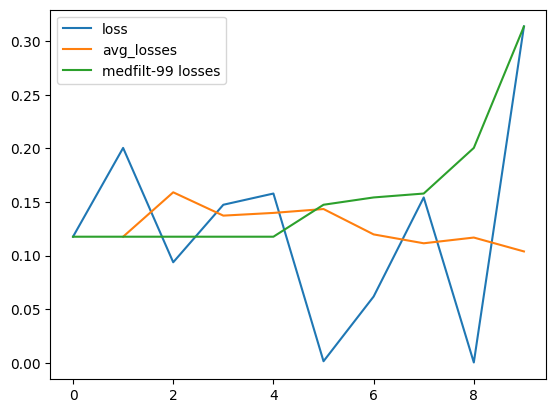

In [19]:
plt.plot(trainData.losses, label="loss")
plt.plot([np.mean(trainData.losses[:i]) for i in range(len(trainData.losses))], label="avg_losses")
def medfilt (x, k): # https://gist.github.com/bhawkins/3535131
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range (k2):
        j = k2 - i
        y[j:,i] = x[:-j]
        y[:j,i] = x[0]
        y[:-j,-(i+1)] = x[j:]
        y[-j:,-(i+1)] = x[-1]
    return np.median (y, axis=1)
plt.plot(medfilt(np.array(trainData.losses), 99), label="medfilt-99 losses")
plt.legend()

In [20]:
#window_index = data.valid_windows[int(np.random.uniform(0,len(data.valid_windows)))]
window_index = expData.valid_windows[100] # any
feature, label, _timestamps, _isvalid = get_datapoint(expData.data_resampled, window_index,expData.window_size,expData.feature_size) 
feature = torch.Tensor(feature).to(device)
label = torch.Tensor(label).to(device)
decoder_input = feature[-2:]
net = trainData.best_net
net.to(device)
net.encode(torch.unsqueeze(feature,0).T)
out = net(decoder_input,mask=None)
out

tensor([[0.4921],
        [0.2306]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [21]:
feature

tensor([[0.8107],
        [0.7945],
        [0.7950],
        [0.7930],
        [0.7361],
        [0.7616],
        [0.7666],
        [0.7381],
        [0.7097],
        [0.7430]], device='cuda:0')

In [22]:
label

tensor([[0.7293],
        [0.7057]], device='cuda:0')

In [23]:
nn.MSELoss()(label,out), trainData.best_loss

(tensor(0.1410, device='cuda:0', grad_fn=<MseLossBackward0>),
 array(0.00036401, dtype=float32))

In [24]:
def saveData(dir: pl.Path, expData: ExperimentData, trainData: TrainingData):
    dir.mkdir(exist_ok=True)
    torch.save(trainData.net.state_dict(), dir / 'model_weights.pt')
    losses = np.array(trainData.losses)
    np.save(dir / "losses",losses)
    torch.save({"d_input":trainData.d_input, "d_model": trainData.d_model}, dir / "model_params.pt")
    dc = asdict(expData)
    dc["data_resampled"] = None
    torch.save(dc, dir / "exp_data.pt")
    print("data saved")

#saveData(pl.Path("../data/experiment/"),expData, trainData)

## Try Inference using trained model and compare with ground truth

In [25]:
def inference(net: TimeSeriesTransformer, input: np.ndarray, prediction_length: int, seed=None):
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
    feature = torch.Tensor(input).to(device)
    net.encode(torch.unsqueeze(feature,0).T)
    
    # we start with last feature label as input
    last_feature = feature[-1] #.cpu().detach().numpy()
    predicted_labels = [last_feature]
    #predicted_labels = [feature[-1]]
    # infer iteratively
    for sp in range(prediction_length):
        decoder_input = predicted_labels[:sp+1]
        decoder_input = torch.Tensor(decoder_input).to(device)
        #decoder_input = torch.unsqueeze(decoder_input,0)
        decoder_input = torch.unsqueeze(decoder_input,0)
        decoder_input = decoder_input.T
        #print(decoder_input.shape)
        out = net.forward(decoder_input,None)
        newly_predicted = out[-1] # always only one new because of shifted label prediction
        predicted_labels.append(newly_predicted.cpu().detach().numpy()) 

    return np.array(predicted_labels[1:])

num_predict = 25
pred = inference(net, feature.cpu().detach().numpy(), num_predict,0)
pred

C:\Users\Julian\AppData\Local\Temp\ipykernel_17144\1709638256.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  decoder_input = torch.Tensor(decoder_input).to(device)


array([[-0.00848594],
       [ 0.1601829 ],
       [ 0.05572081],
       [ 0.2143337 ],
       [ 0.3622947 ],
       [ 0.37399837],
       [ 0.33395842],
       [ 0.6123888 ],
       [ 0.2822026 ],
       [ 0.2725913 ],
       [-0.114822  ],
       [ 0.32718584],
       [ 0.6401865 ],
       [ 0.7958943 ],
       [ 0.1522509 ],
       [ 0.34521604],
       [ 0.7095487 ],
       [ 0.26536626],
       [ 0.5020725 ],
       [ 0.2361487 ],
       [ 0.34506184],
       [ 0.1527383 ],
       [ 0.3136009 ],
       [ 0.60748625],
       [-0.04263686]], dtype=float32)

In [26]:
# minmaxed transpiration data starting from selected window until prediction end
ground_truth = expData.data_resampled.iloc[window_index:window_index+feature.shape[0]+num_predict]
ground_truth_transpiration = ground_truth["transpiration"]
ground_truth_timestamps = ground_truth["timestamp"]
ground_truth_transpiration.shape

(35,)

nearest timestamp from sampled timestamp index for comparison

In [27]:
timestamp = [data_temp[data_temp.timestamp < ground_truth_timestamps.iloc[0]].iloc[-1], data_temp[data_temp.timestamp > ground_truth_timestamps.iloc[0]].iloc[0]][1]
timestamp

timestamp                     2022-01-22 14:02:01
differential_potential_CH1                 522810
differential_potential_CH2                 500395
transpiration                                 560
Name: 288, dtype: object

In [28]:
def rescale(data:np.ndarray, scaler:skp.MinMaxScaler, index:int):
    base = np.zeros((data.shape[0],scaler.feature_names_in_.shape[0]))
    base[:,index] = data
    rev = scaler.inverse_transform(base)
    return rev[:,index]
rescale(ground_truth_transpiration,scaler,2)

array([562.        , 556.5       , 556.66666667, 556.        ,
       536.66666667, 545.33333333, 547.        , 537.33333333,
       527.66666667, 539.        , 534.33333333, 526.33333333,
       533.66666667, 533.66666667, 541.66666667, 560.66666667,
       550.        , 533.66666667, 508.        , 518.66666667,
       533.        , 518.66666667, 529.        , 519.33333333,
       517.        , 508.        , 528.5       , 528.        ,
       536.        , 538.33333333, 546.66666667, 525.        ,
       493.66666667, 466.66666667, 496.        ])

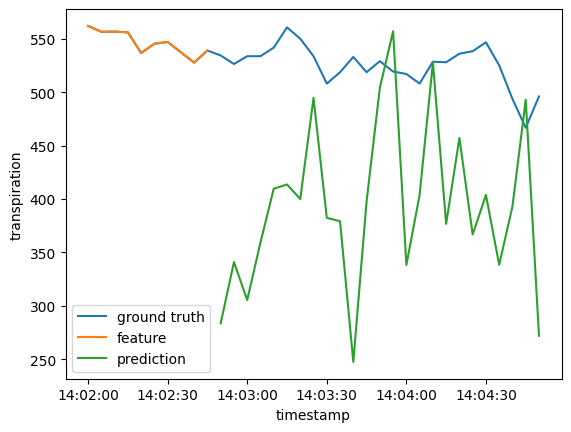

In [29]:
xs = [i for i in range(feature.shape[0]+num_predict)]
plt.plot(ground_truth_timestamps,rescale(ground_truth_transpiration, scaler,2), label="ground truth")
plt.plot(ground_truth_timestamps[:feature.shape[0]],rescale(feature.cpu().detach().numpy()[:,0],scaler,2), label="feature")
plt.plot(ground_truth_timestamps[feature.shape[0]:],rescale(pred[:,0],scaler,2), label="prediction")
plt.xlabel("timestamp")
plt.ylabel("transpiration")
plt.legend()

## Parameter Study

In [278]:

# def get_linear_experiment_data():
#     df = pd.DataFrame(np.array([0.2 * i + 10 for i in range(0,1000)]).astype(float), columns=["data"])
#     startdate = datetime.datetime(23,1,1,0)
#     df.insert(loc=0, column="timestamp",value=[startdate + datetime.timedelta(seconds=i) for i in df["data"]])
#     return ExperimentData(df, skp.MinMaxScaler(), "1s", "mean", ["data"], 8, 2, list(range(0,900)))
# expDataB = get_linear_experiment_data()

def get_linear_data():
    df = pd.DataFrame(np.array([0.2 * i + 10 for i in range(0,100)]).astype(float), columns=["data"])
    startdate = datetime.datetime(year=2023,month=1,day=1)
    df.insert(loc=0, column="timestamp",value=[np.datetime64(startdate+ datetime.timedelta(seconds=i)) for i in df["data"]])
    return getExperimentData(df, "1s", "mean", ["data"], 8, 2)

expDataB = get_linear_data()
#t = expDataB["timestamp"][0]

computing valid windows


100%|██████████| 20/20 [00:00<00:00, 3999.34it/s]

found 13 valid window(s)


In [279]:
hyperparams = {
    "d_model": 16,
    "nhead": 16,
    "learning_rate": 1e-3,
    "num_epochs": 200,
    "seed": 0,
}
trainData = trainExperiment(expDataB, **hyperparams) # 10000

using learning rate 1e-50
0: avg_loss=0.10407322645187378
1: avg_loss=0.44835004210472107
2: avg_loss=0.13787920773029327
3: avg_loss=0.4757378101348877
4: avg_loss=0.11595840752124786
5: avg_loss=0.17612294852733612
6: avg_loss=0.20074555277824402
7: avg_loss=0.2586822211742401
8: avg_loss=0.1718297302722931
9: avg_loss=0.4453447759151459
10: avg_loss=0.45318323373794556
11: avg_loss=0.5406461954116821
12: avg_loss=0.21637915074825287
13: avg_loss=0.10991059243679047
14: avg_loss=0.5147601962089539
15: avg_loss=0.5545928478240967
16: avg_loss=1.1441508531570435
17: avg_loss=0.47087907791137695
18: avg_loss=0.30000466108322144
19: avg_loss=0.2494567334651947
20: avg_loss=0.3085014522075653
21: avg_loss=0.5442306995391846
22: avg_loss=0.030016636475920677
23: avg_loss=0.41013190150260925
24: avg_loss=0.9286991357803345
25: avg_loss=0.8726091384887695
26: avg_loss=1.3143882751464844
27: avg_loss=0.2851221561431885
28: avg_loss=0.982965350151062
29: avg_loss=0.15671202540397644
30: avg_lo

In [ ]:
input, timestamps, isvalid = get_window(expDataB.data_resampled, 0, 8)
input

array([[0.        ],
       [0.00502513],
       [0.01005025],
       [0.01507538],
       [0.0201005 ],
       [0.02512563],
       [0.03015075],
       [0.03517588]])

In [ ]:
net = trainData.best_net
trainData.best_loss

array(0.00106067, dtype=float32)

In [ ]:
feature = torch.Tensor(input).to(device)
net.encode(torch.unsqueeze(feature,0).T)

# we start with last feature label as input
last_feature = feature[-1] #.cpu().detach().numpy()
predicted_labels = [last_feature]
#predicted_labels = [feature[-1]]
# infer iteratively
for sp in range(10):
    decoder_input = predicted_labels[:sp+1]
    decoder_input = torch.Tensor(decoder_input).to(device)
    #decoder_input = torch.unsqueeze(decoder_input,0)
    decoder_input = torch.unsqueeze(decoder_input,0)
    decoder_input = decoder_input.T
    #print(decoder_input.shape)
    out = net.forward(decoder_input,None)
    newly_predicted = out[-1] # always only one new because of shifted label prediction
    predicted_labels.append(newly_predicted.cpu().detach().numpy()) 

predicted_labels[1:]

[array([0.33922186], dtype=float32),
 array([0.28882414], dtype=float32),
 array([0.49586883], dtype=float32),
 array([0.35034895], dtype=float32),
 array([0.29159504], dtype=float32),
 array([0.3107763], dtype=float32),
 array([0.2891994], dtype=float32),
 array([0.3281615], dtype=float32),
 array([0.20246962], dtype=float32),
 array([0.28244737], dtype=float32)]

using net with best loss of 0.0010606747
[[0.51256281]
 [0.51758794]
 [0.52261307]
 [0.52763819]
 [0.53266332]
 [0.53768844]]


c:\Users\Julian\code\uni\seminar\venv\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Julian\code\uni\seminar\venv\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


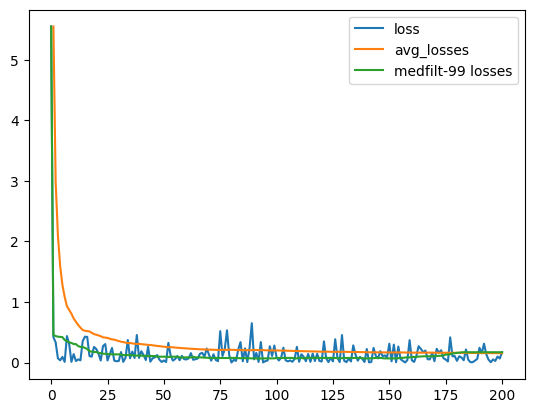

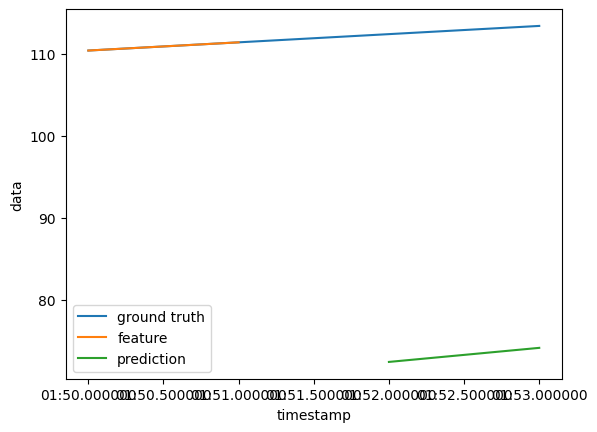

In [ ]:
def validate_model(net,expData,window_index,column,num_predict = 25):
    feature, label, _timestamps, _isvalid = get_datapoint(expData.data_resampled, window_index,expData.window_size,expData.feature_size) 
    feature = torch.Tensor(feature).to(device)
    print(label)
    pred = inference(net, feature.cpu().detach().numpy(), num_predict,0)
    pred
    ground_truth = expData.data_resampled.iloc[window_index:window_index+feature.shape[0]+num_predict]
    ground_truth_transpiration = ground_truth[column]
    ground_truth_timestamps = ground_truth["timestamp"]
    ground_truth_transpiration.shape
    xs = [i for i in range(feature.shape[0]+num_predict)]
    scaler = expData.scaler
    plt.figure()
    plt.plot(ground_truth_timestamps,rescale(ground_truth_transpiration, scaler,0), label="ground truth")
    plt.plot(ground_truth_timestamps[:feature.shape[0]],rescale(feature.cpu().detach().numpy()[:,0],scaler,0), label="feature")
    plt.plot(ground_truth_timestamps[feature.shape[0]:],rescale(pred[:,0],scaler,0), label="prediction")
    plt.xlabel("timestamp")
    plt.ylabel(column)
    plt.legend()

def validate_window(trainData, expData, w=0,c=0,n_pred=2):
    net = trainData.best_net
    print("using net with best loss of",trainData.best_loss)
    net = net.to(device)
    validate_model(net, expData, expData.valid_windows[w], expData.columns[c], n_pred)

def show_losses(trainData):
    plt.figure()
    plt.plot(trainData.losses, label="loss")
    plt.plot([np.mean(trainData.losses[:i]) for i in range(len(trainData.losses))], label="avg_losses")
    def medfilt (x, k): # https://gist.github.com/bhawkins/3535131
        """Apply a length-k median filter to a 1D array x.
        Boundaries are extended by repeating endpoints.
        """
        assert k % 2 == 1, "Median filter length must be odd."
        assert x.ndim == 1, "Input must be one-dimensional."
        k2 = (k - 1) // 2
        y = np.zeros ((len (x), k), dtype=x.dtype)
        y[:,k2] = x
        for i in range (k2):
            j = k2 - i
            y[j:,i] = x[:-j]
            y[:j,i] = x[0]
            y[:-j,-(i+1)] = x[j:]
            y[-j:,-(i+1)] = x[-1]
        return np.median (y, axis=1)
    plt.plot(medfilt(np.array(trainData.losses), 99), label="medfilt-99 losses")
    plt.legend()


show_losses(trainData)
validate_window(trainData, expDataB, w=100)